Evaluate `gpytorch` on the 1d test example from `hetGP`

In [25]:
from rpy2.robjects import r
import numpy as np
from scipy.stats import norm
r('''
library(hetGP)

X    = seq(from=0, to=1, length.out=200)
reps = sample(1:20,size = length(X), replace = T)
X    = matrix(X[rep(1:length(X),reps)],ncol=1)

Z    = f1d(X) + rnorm(n=nrow(X), sd = 3)
''')
X = np.array(r('X'))
Z = np.array(r('Z')).squeeze()
xgrid = np.linspace(0,1,1000)

In [111]:
# use gpytorch
# source: https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html
# simplest form of GP model, exact inference
import gpytorch
import torch
from time import time
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp = ExactGPModel(
    torch.from_numpy(X), 
    torch.from_numpy(Z), 
    likelihood)
training_iter = 200
# Find optimal model hyperparameters
gp.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(gp.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
s = time()
losses = np.zeros(shape=training_iter)
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = gp(torch.from_numpy(X))
    # Calc loss and backprop gradients
    loss = -mll(output, torch.from_numpy(Z))
    loss.backward()
    optimizer.step()
    losses[i] = loss.item()
e = time() - s
# eval
gp.eval()
likelihood.eval()

with torch.no_grad():
    gpytorch_preds = likelihood(gp(torch.from_numpy(xgrid)))
    nugs = likelihood.noise_covar.noise.item()
    sd2  = gpytorch_preds.variance.numpy()
    gpytorch_lower = norm.ppf(0.05,gpytorch_preds.mean.numpy(),np.sqrt(sd2+ nugs))
    gpytorch_upper = norm.ppf(0.95,gpytorch_preds.mean.numpy(),np.sqrt(sd2+ nugs))
print(f"GPyTorch trained in: {round(e,2)} seconds")

GPyTorch trained in: 36.1 seconds


In [112]:
from hetgpy.homGP import homGP
model = homGP()
model.mleHomGP(
    X = X,
    Z = Z,
    lower = np.array([0.1]),
    upper = np.array([5]),
    covtype = "Gaussian"
)
preds = model.predict(xgrid)
preds['upper'] = norm.ppf(0.95, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()
preds['lower'] = norm.ppf(0.05, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()
print(f"homGP trained in: {round(model.time,2)} seconds")
print(model.ll)

homGP trained in: 0.08 seconds
-5183.213252500444


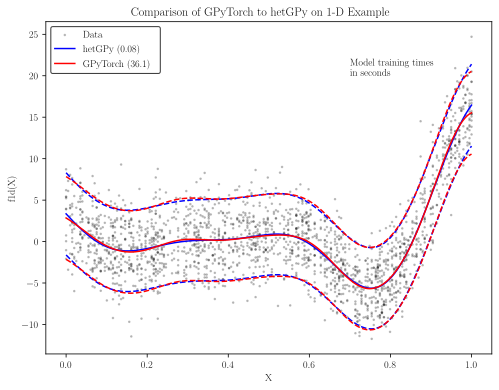

In [136]:
# plot
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
fig, ax = plt.subplots(figsize = (8,6))
xs = xgrid.squeeze()
ax.scatter(X.squeeze(), Z,color='k',label = 'Data',alpha=0.2,s=3)
ax.plot(xs, preds['mean'],'b',label=f'hetGPy ({round(model.time,2)})')
ax.plot(xs, preds['upper'],'b--')
ax.plot(xs, preds['lower'],'b--')
ax.plot(xs,gpytorch_preds.mean.numpy(),'r',label=f'GPyTorch ({round(e,2)})')
ax.plot(xs,gpytorch_lower,'r--')
ax.plot(xs,gpytorch_upper,'r--')
ax.legend(markerscale=60)  
ax.legend().get_frame().set_edgecolor('black')
leg = plt.legend()  
plt.legend().get_frame().set_edgecolor('black')
for lh in leg.legend_handles: 
    lh.set_alpha(1)
ax.set_ylabel("f1d(X)")
ax.set_xlabel("X")
ax.annotate('Model training times\nin seconds', xy=(0.70, 20))
ax.set_title("Comparison of GPyTorch to hetGPy on 1-D Example")
fig.savefig('figs/hetGPy-GPyTorch-1D.pdf')